In [40]:
# from model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import pandas as pd 
import os 
from torch.optim import lr_scheduler

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


def validate(val_loader, model):
    model.eval()
    correct_g = 0
    correct_v = 0
    correct_c = 0
    
    l = len(val_loader.dataset)
    
    for _, sample in enumerate(val_loader):
        if torch.cuda.is_available():
            data = sample['image'].cuda()
            target_grapheme = sample['labels']['grapheme_labels'].cuda()
            target_vowel = sample['labels']['vowel_labels'].cuda()
            target_consonant = sample['labels']['consonant_labels'].cuda()
        
        output = model(data)
        
#         loss += criterion(output, target).data.item()

        pred_g = output['grapheme'].max(1, keepdim=True)[1]
        correct_g += pred_g.eq(target_grapheme.view_as(pred_g)).cpu().sum()

        pred_v = output['vowel'].max(1, keepdim=True)[1]
        correct_v += pred_v.eq(target_vowel.view_as(pred_v)).cpu().sum()

        pred_c = output['consonant'].max(1, keepdim=True)[1]
        correct_c += pred_c.eq(target_consonant.view_as(pred_c)).cpu().sum()
        
        break

#     loss /= len(val_loader.dataset)
        
    print(f'\nOn Val set Accuracy: grapheme root: {correct_g}/{l} ({round(100.0 * float(correct_g)/l,2)}%) ' +
          f'vowel diatric: {correct_v}/{l} ({round(float(correct_v)/l*100,2)}%) '  + 
          f'consonant diatric: {correct_c}/{l} ({round(float(correct_c)/l*100,2)}%) \n')
    

cuda:0


In [41]:
class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=1292) # Based on ResNet18
        # super(MNISTResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10) # Based on ResNet34
        # super(MNISTResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=10) # Based on ResNet50
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)

        self.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=168)
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=11)
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=7)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
#         x = self.fc(x)
#         x = self.fc1(x)
#         x = self.fc2(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)
#         print(x.shape)

        return {
            'grapheme': self.fc(x),
            'vowel': self.fc1(x),
            'consonant': self.fc2(x)
        }

    def get_loss(self, net_output, ground_truth):
        color_loss = F.cross_entropy(net_output['grapheme'], ground_truth['grapheme_labels'])
        gender_loss = F.cross_entropy(net_output['vowel'], ground_truth['vowel_labels'])
        article_loss = F.cross_entropy(net_output['consonant'], ground_truth['consonant_labels'])
        loss = color_loss + gender_loss + article_loss
        return loss, {'grapheme': color_loss, 'vowel': gender_loss, 'consonant': article_loss}



model = MNISTResNet()
model.to(device)

MNISTResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

model

In [42]:
class BengaliDatasetMultiClass(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.label_df = pd.read_csv(csv_file)
        self.label_df = self.label_df[['image_id','grapheme_root',
                             'vowel_diacritic','consonant_diacritic',
                             'label','grapheme','textlabel']]
        
        self.root_dir = root_dir 
        self.transform = transform 
    
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                                self.label_df.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('L')

        label = tuple(self.label_df.iloc[idx, 1:])
        textlabel = self.label_df.iloc[idx, -1]  
        
        if self.transform:
            image = self.transform(image)
            
        sample = {
            "image": image,
            "labels": {
                "grapheme_labels": label[0],
                "vowel_labels": label[1],
                "consonant_labels": label[2],
            },
            "human_labels":{
                "typeface":label[4],
                "stringlabel":label[5]
            }
        }

        return sample

In [43]:
batch_size=128
num_workers = 16

transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

trainset = BengaliDatasetMultiClass("data/train.csv","data/trainsplit", transform)
testset = BengaliDatasetMultiClass("data/test.csv","data/testsplit", transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

In [44]:
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def calculate_metrics(output, target):
    _, predicted_color = output['grapheme'].cpu().max(1)
    gt_color = target['grapheme_labels'].cpu()

    _, predicted_gender = output['vowel'].cpu().max(1)
    gt_gender = target['vowel_labels'].cpu()

    _, predicted_article = output['consonant'].cpu().max(1)
    gt_article = target['consonant_labels'].cpu()

    with warnings.catch_warnings():  # sklearn may produce a warning when processing zero row in confusion matrix
        warnings.simplefilter("ignore")
        accuracy_color = accuracy_score(y_true=gt_color.numpy(), y_pred=predicted_color.numpy())
        accuracy_gender = accuracy_score(y_true=gt_gender.numpy(), y_pred=predicted_gender.numpy())
        accuracy_article = accuracy_score(y_true=gt_article.numpy(), y_pred=predicted_article.numpy())

    return accuracy_color, accuracy_gender, accuracy_article

In [45]:
# from train.py

import argparse
import os
from datetime import datetime

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter


def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')


def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)

    return f
    

def train(start_epoch=1, N_epochs=20, log_interval=100):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


    for epoch in range(start_epoch, N_epochs + 1):
        total_loss = 0
        accuracy_g = 0
        accuracy_v = 0
        accuracy_c = 0

        for i, batch in enumerate(trainloader):
            optimizer.zero_grad()

            img = batch['image']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            batch_accuracy_g, batch_accuracy_v, batch_accuracy_c = \
                calculate_metrics(output, target_labels)

            accuracy_g += batch_accuracy_g
            accuracy_v += batch_accuracy_v
            accuracy_c += batch_accuracy_c

            loss_train.backward()
            optimizer.step()
            
            if (i+1)%log_interval == 0: 
                print("epoch {:4d}, loss: {:.4f}, grapheme: {:.4f}, vowel: {:.4f}, consonant: {:.4f}".format(
                    epoch,
                    total_loss / (log_interval*batch_size),
                    accuracy_g / (log_interval*batch_size),
                    accuracy_v / (log_interval*batch_size),
                    accuracy_c / (log_interval*batch_size)))
                
                # Reset stats 
                total_loss = 0
                accuracy_color = 0
                accuracy_gender = 0
                accuracy_article = 0
                
        validate(testloader, model)


In [54]:
train()

epoch    1, loss: 0.0034, grapheme: 0.0070, vowel: 0.0077, consonant: 0.0077
epoch    1, loss: 0.0032, grapheme: 0.0141, vowel: 0.0153, consonant: 0.0153
epoch    1, loss: 0.0033, grapheme: 0.0212, vowel: 0.0230, consonant: 0.0230
epoch    1, loss: 0.0036, grapheme: 0.0282, vowel: 0.0306, consonant: 0.0306
epoch    1, loss: 0.0034, grapheme: 0.0353, vowel: 0.0383, consonant: 0.0383
epoch    1, loss: 0.0036, grapheme: 0.0423, vowel: 0.0459, consonant: 0.0459
epoch    1, loss: 0.0037, grapheme: 0.0492, vowel: 0.0536, consonant: 0.0535
epoch    1, loss: 0.0038, grapheme: 0.0562, vowel: 0.0612, consonant: 0.0611
epoch    1, loss: 0.0037, grapheme: 0.0632, vowel: 0.0689, consonant: 0.0688
epoch    1, loss: 0.0038, grapheme: 0.0702, vowel: 0.0765, consonant: 0.0764

On Val set Accuracy: grapheme root: 102/66278 (0.15%) vowel diatric: 125/66278 (0.19%) consonant diatric: 121/66278 (0.18%) 

epoch    2, loss: 0.0026, grapheme: 0.0072, vowel: 0.0077, consonant: 0.0077
epoch    2, loss: 0.0027, 

epoch   10, loss: 0.0015, grapheme: 0.0224, vowel: 0.0232, consonant: 0.0232
epoch   10, loss: 0.0016, grapheme: 0.0298, vowel: 0.0309, consonant: 0.0310
epoch   10, loss: 0.0020, grapheme: 0.0372, vowel: 0.0387, consonant: 0.0387
epoch   10, loss: 0.0018, grapheme: 0.0446, vowel: 0.0464, consonant: 0.0464
epoch   10, loss: 0.0018, grapheme: 0.0520, vowel: 0.0541, consonant: 0.0541
epoch   10, loss: 0.0017, grapheme: 0.0594, vowel: 0.0619, consonant: 0.0618
epoch   10, loss: 0.0018, grapheme: 0.0668, vowel: 0.0696, consonant: 0.0695
epoch   10, loss: 0.0019, grapheme: 0.0742, vowel: 0.0773, consonant: 0.0773

On Val set Accuracy: grapheme root: 110/66278 (0.17%) vowel diatric: 120/66278 (0.18%) consonant diatric: 125/66278 (0.19%) 

epoch   11, loss: 0.0013, grapheme: 0.0075, vowel: 0.0078, consonant: 0.0078
epoch   11, loss: 0.0016, grapheme: 0.0150, vowel: 0.0155, consonant: 0.0155
epoch   11, loss: 0.0017, grapheme: 0.0224, vowel: 0.0232, consonant: 0.0232
epoch   11, loss: 0.0017, 

Process Process-786:
Process Process-792:
Process Process-787:
Process Process-791:
Process Process-785:
Process Process-788:
Process Process-789:
Process Process-799:
Process Process-795:
Process Process-790:
Process Process-796:
Process Process-793:
Process Process-800:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-798:
Process Process-797:
Process Process-794:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/hom

  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 192, in _finalize_join
    thread.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queu

KeyboardInterrupt: 

In [49]:
# calculate_metrics(output, samples["labels"])

In [55]:
torch.save(model.state_dict(), "multilabel_resnet")

In [56]:
validate(testloader, model)


On Val set Accuracy: grapheme root: 114/66278 (0.17%) vowel diatric: 123/66278 (0.19%) consonant diatric: 124/66278 (0.19%) 



In [57]:
sample = next(iter(testloader))

In [58]:
sample = next(iter(testloader))
output = model(sample['image'].to(device))
labels = sample['labels']['grapheme_labels']
pred = output['grapheme'].max(1, keepdim=True)[1].cpu()

0.84375


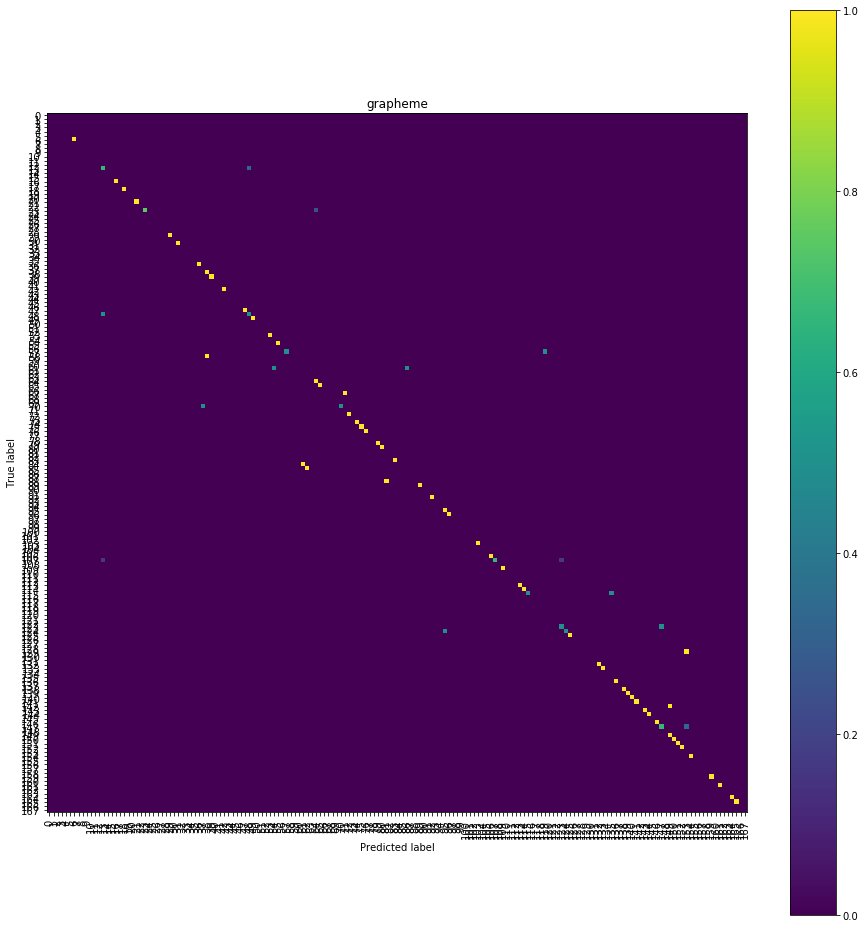

0.9453125


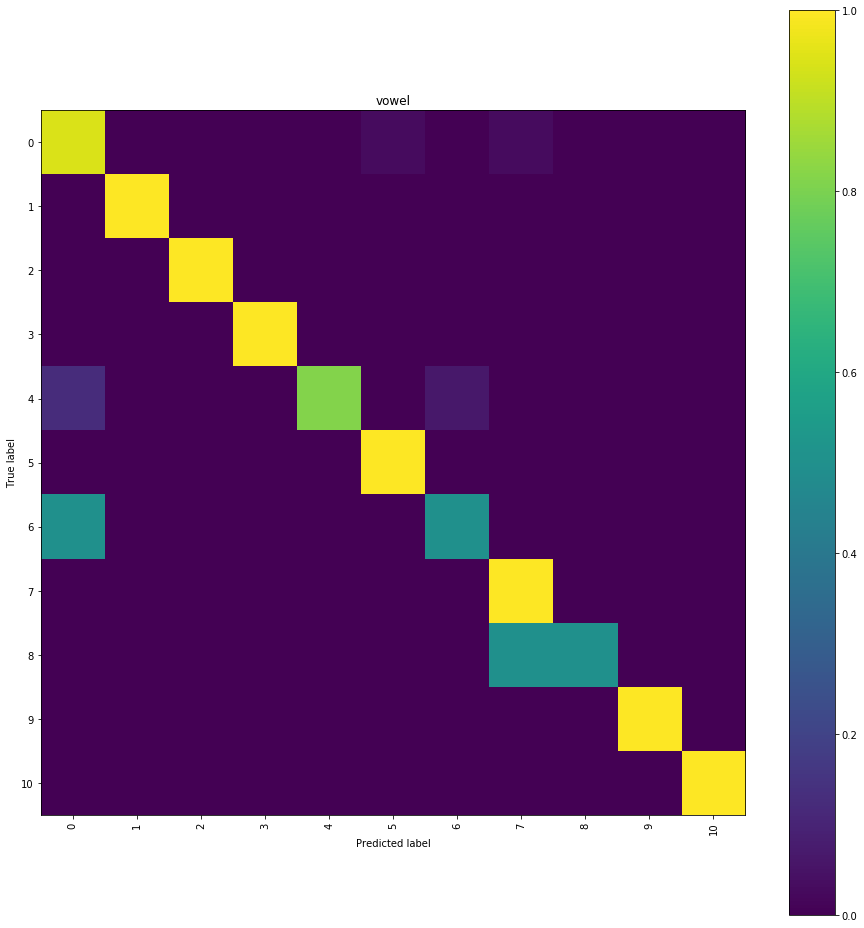

0.9765625


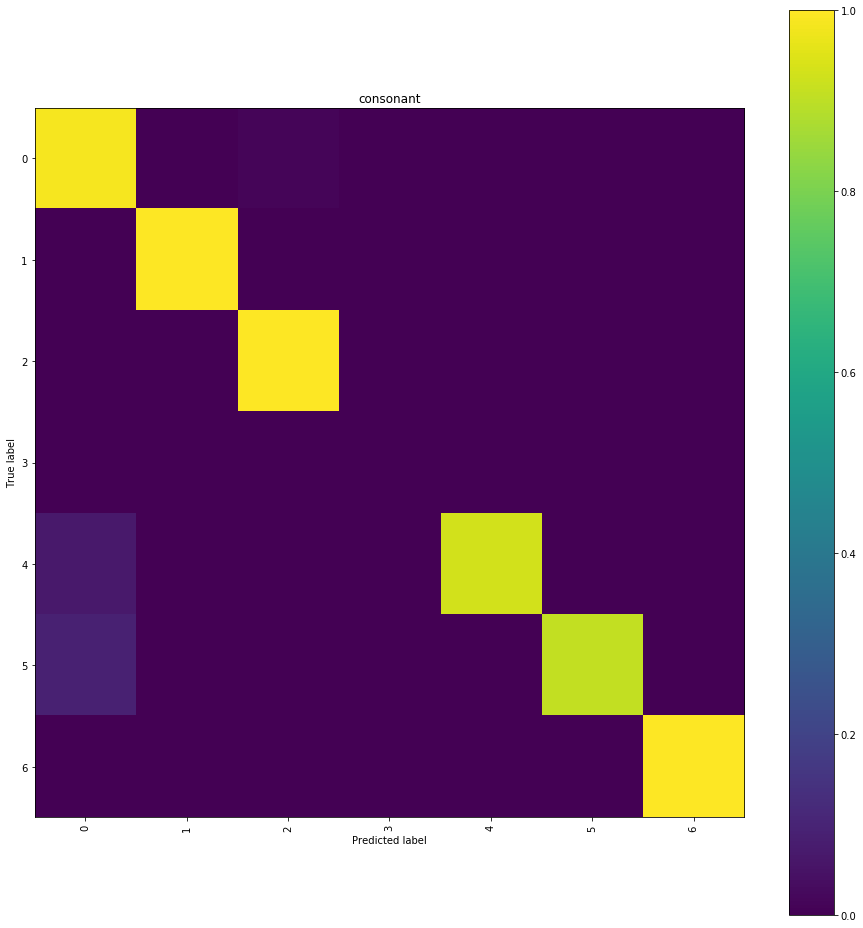

In [63]:
from sklearn.metrics import plot_confusion_matrix
import sklearn
import matplotlib.pyplot as plt 
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay
)

from pylab import rcParams
rcParams['figure.figsize'] = 13, 13

n_classes = [168, 11, 7]

for j,i in enumerate(['grapheme','vowel','consonant']):
    labels = sample['labels'][i+'_labels']
    pred = output[i].max(1, keepdim=True)[1].cpu()

    print(sklearn.metrics.accuracy_score(labels, pred))


    # plt.figure(figsize=(12,12))
    cn_matrix = confusion_matrix(
        y_true=labels.numpy(),
        y_pred=pred,
        labels=list(range(n_classes[j])),
        normalize="true",
    )
    ConfusionMatrixDisplay(cn_matrix, list(range(n_classes[j]))).plot(
        include_values=False, xticks_rotation="vertical"
    )
    plt.title(i)

    plt.tight_layout()
    plt.show()

In [64]:
sample['labels']

{'grapheme_labels': tensor([147, 115, 149, 147,  96, 133,  75,  70,  75, 154, 107,  23, 106,  64,
          42,  65, 149,  13,  83,  23,  95,  42, 143,  57, 103, 123,  49, 140,
          80,  42,  16, 159, 114, 107,  65,  48, 164, 159,  13,  55,  13, 147,
          53, 124,  53,  47,  48, 133,  96, 161, 133, 123,  72,  58,  23,  42,
          38,  84,  70, 146, 129,  88,  42,  64, 132, 133, 159, 142,  89,   6,
         149, 150,  42,  47,  79, 125,  67,  18,  31,  21,  61,  64, 141,  74,
         113,  61, 125, 138, 136,  85,  16,  75,  75,  21, 107,  23, 115, 107,
          72, 132, 149, 107, 106,  72,  53,  72, 144, 109,  57,  38,  36,  76,
         124,  38, 151,  21,  39,  31,  89,  92, 139,  38, 152, 150, 165,  29,
         107, 133]),
 'vowel_labels': tensor([ 4,  0,  9,  0,  3,  7,  0,  0,  7,  3,  4,  2,  7,  0,  1,  0,  2, 10,
          9,  0,  7,  7,  1,  2,  0,  9,  0,  3,  0,  1,  2,  0,  1,  9,  0,  4,
          0,  4,  1,  4,  2,  5,  7,  1,  1,  2,  4,  3,  0,  0,  0,  8

In [52]:
print("hi")

hi


In [60]:
cn_matrix

array([[0.98765432, 0.        , 0.01234568, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.06666667, 0.        , 0.        , 0.        , 0.93333333,
        0.        , 0.        ],
       [0.09090909, 0.        , 0.        , 0.        , 0.        ,
        0.90909091, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ]])